<center>
    <font size="5" color="steelblue"><b>Universidad Nacional de Colombia</b></font><br>
    <font size="5" color="steelblue"><b>Unidad de Informática - Facultad de Ciencias Económicas</b></font><br>
    <font size="5" color="steelblue"><b>Curso Libre Machine Learning con Python | 2023-1</b></font><br>
    <font size="5" color="steelblue"><b>Semana 4: Aprendizaje Supervisado Caso Aplicado</b></font><br>
    <font size="5" color="steelblue"><b>Estudiante Auxiliar: Jaime Andrés Fierro Aponte</b></font><br>
</center>

# Dependencias

In [4]:
# Manejo de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Machine Learning
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, balanced_accuracy_score)


In [5]:
# Función para graficar el área bajo la curva ROC
def auc_roc(y_true, y_predicted):

  plt.figure(figsize=(5, 5))

  tpr,fpr,_ = roc_curve(y_true, y_predicted)
  roc_auc = 1 - auc(fpr, tpr)
  plt.plot(tpr, fpr, color='darkorange', lw=2,
          label='Curva ROC (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('% Falso Positivo')
  plt.ylabel('% Verdadero Positivo')
  plt.title('Curva ROC')
  plt.legend(loc='lower right')



# Importación de datos

El conjunto de datos recupera información sobre los clientes de un banco. Éstos datos fueron construídos para el análisis sobre la cancelación de productos creditios por parte de algunos clientes. Las variables disponibles son las siguientes:

* **CLIENTNUM**: Número de cliente. Identificador único del cliente titular de la cuenta
* **Attrition_Flag**: Actividad del cliente - Cliente que abandonó o cliente que aún existe
* **Customer_Age**: Variable demográfica - Edad del cliente en años
* **Gender**: Variable demográfica - M=Male, F=Female
* **Dependent_count**: Variable demográfica - Número de dependientes
* **Education_Level**: Variable demográfica**: Nivel educativo - Nivel educativo del titular de la cuenta (high school, college graduate, etc.)
* **Marital_Status**: Variable demográfica**: Estado civil - Married, Single, Divorced, Unknow
* **Income**: Variable demográfica**: Ingreso - Ingreso anual del titular de la cuenta
* **Card_Category**: Varible del producto - Tipo de la tarjeta (Blue, Silver, Gold, Platinum)
* **Months_on_book**: Periodo de relación con el banco
* **Total_Relationship_Count**: Número total de productos obtenidos por el cliente
* **Months_Inactive_12_mon**: Número de meses inactivo en los últimos 12 meses
* **Contacts_Count_12_mon**: Número de contactos en los últimos 12 meses
* **Credit_Limit**: Límite de crédito en la tarjeta de crédito
* **Total_Revolving_Bal**: Saldo rotatorio total en la tarjeta de crédito
* **Avg_Open_To_Buy**: Línea de crédito abierta para comprar (promedio de los últimos 12 meses)
* **Total_Amt_Chng_Q4_Q1**: Cambio en el monto de la transacción (Q4 sobre Q1)
* **Total_Trans_Amt**: Monto total de transacción (últimos 12 meses)
* **Total_Trans_Ct**: Cantidad total de transacciones (últimos 12 meses)
* **Total_Ct_Chng_Q4_Q1**: Cambio en la cantidad total de transacciones (Q4 sobre Q1)
* **Avg_Utilization_Ratio**: Ratio de uso promedio de la tarjeta

In [6]:
# Importar los datos
bank_attrited = pd.read_excel('../data/Bank Attrited Customers.xlsx')
bank_attrited

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,70376.50,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42.0,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,20006.60,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33.0,3.714,0.105
2,713982108,Existing Customer,51,NaN,3,Graduate,Married,111901.58,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20.0,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,25607.43,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20.0,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,66669.58,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28.0,2.500,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10139,772366833,Existing Customer,50,M,2,Graduate,Single,45227.76,Blue,40,...,2,3,4003.0,1851,2152.0,0.703,15476,117.0,0.857,0.462
10140,710638233,Attrited Customer,41,M,2,NaN,Divorced,40187.47,Blue,25,...,2,3,4277.0,2186,2091.0,0.804,8764,69.0,0.683,0.511
10141,716506083,Attrited Customer,44,F,1,High School,Married,416.97,Blue,36,...,3,4,5409.0,0,5409.0,0.819,10291,60.0,0.818,0.000
10142,717406983,Attrited Customer,30,M,2,Graduate,NaN,44482.74,Blue,36,...,3,3,5281.0,0,5281.0,0.535,8395,62.0,0.722,0.000


## Exploración Inicial

In [7]:
# Tipo de objeto
type(bank_attrited)

pandas.core.frame.DataFrame

In [8]:
# Tipo de datos por variable
bank_attrited.dtypes

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income                      float64
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct              float64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
dtype: object

In [9]:
# Dimensiones
bank_attrited.shape

(10144, 21)

In [10]:
# Conteo de datos nulos
bank_attrited.isna().sum()
# Para tratar los datos nulos, revisar algoritmo MICE (Multiple Imputation in Chained Equations)

CLIENTNUM                      0
Attrition_Flag                 0
Customer_Age                   0
Gender                        42
Dependent_count                0
Education_Level             1521
Marital_Status               750
Income                      1115
Card_Category                  0
Months_on_book                 0
Total_Relationship_Count       0
Months_Inactive_12_mon         0
Contacts_Count_12_mon          0
Credit_Limit                  17
Total_Revolving_Bal            0
Avg_Open_To_Buy                0
Total_Amt_Chng_Q4_Q1           0
Total_Trans_Amt                0
Total_Trans_Ct               198
Total_Ct_Chng_Q4_Q1            0
Avg_Utilization_Ratio          0
dtype: int64

In [11]:
# Información general
bank_attrited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10144 entries, 0 to 10143
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10144 non-null  int64  
 1   Attrition_Flag            10144 non-null  object 
 2   Customer_Age              10144 non-null  int64  
 3   Gender                    10102 non-null  object 
 4   Dependent_count           10144 non-null  int64  
 5   Education_Level           8623 non-null   object 
 6   Marital_Status            9394 non-null   object 
 7   Income                    9029 non-null   float64
 8   Card_Category             10144 non-null  object 
 9   Months_on_book            10144 non-null  int64  
 10  Total_Relationship_Count  10144 non-null  int64  
 11  Months_Inactive_12_mon    10144 non-null  int64  
 12  Contacts_Count_12_mon     10144 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [12]:
# Eliminar variable identificadora
datos = bank_attrited.copy()
datos = datos.drop(columns='CLIENTNUM')\
             .dropna()

In [13]:
datos.shape

(6922, 20)

# Selección de variables

## Análisis de correlación

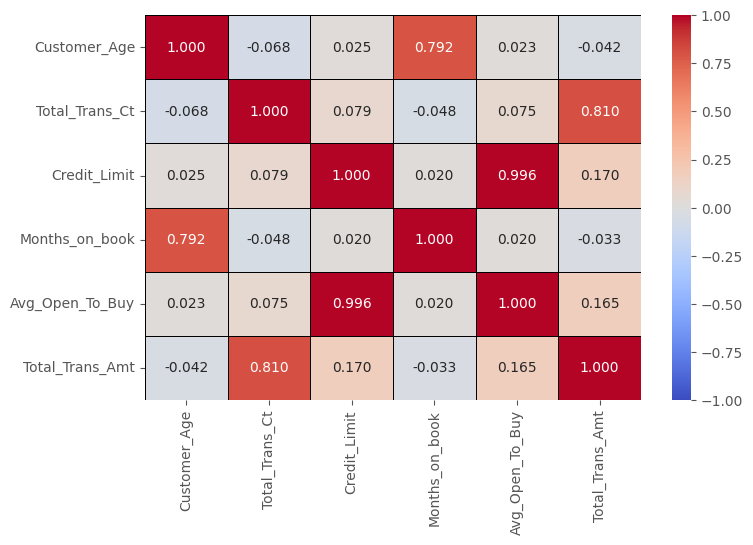

In [14]:
# Calcular la matriz de correlación
corr_matrix = datos.corr(numeric_only=True)

# Matriz de correlación reducida

# Variables que tienen alta correlación
high_corrs = [
              (i, j)
              for i in corr_matrix.columns
              for j in corr_matrix.index
              if (np.abs(corr_matrix.loc[i, j]) >= 0.7) & (i != j)
             ]

# Lista con las variables después del filtro
lista_high_corrs = []
for i in range(len(high_corrs)):
  el_1 = high_corrs[i][0]
  el_2 = high_corrs[i][1]
  lista_high_corrs.extend([el_1, el_2])

# Variables únicas de la lista de variables
vars_high_corrs = list(set(lista_high_corrs))

# Matríz de correlación reducida
small_corr_matrix = datos[vars_high_corrs].corr()

# Heatmap de correlación
plt.figure(figsize=(8, 5))
sns.heatmap(small_corr_matrix,
            annot=True,
            linewidths=0.5,
            linecolor='black',
            vmin=-1,
            vmax=1,
            fmt = '.3f',
            cmap='coolwarm')
plt.show()

Varias soluciones se pueden aplicar en los casos de correlaciones altas. Por ejemplo, probar con PCA en las variables que están muy correlacionadas, o análisis factorial. Se puede intentar transformar algunas de las variables con correlación, aplicando distintos tipos de funciones, como la logarítmica, curva power, curva S, entre otros, dependiendo de lo que tenga sentido analítico. Otra opción es sumar o promediar las variables, dependiendo de las características que tengan y del sentido analítico que se le de dentro del negocio.

In [31]:
# Para el caso de ejemplo que estamos viendo, eliminaremos las variables correlacionadas
# con base en la experiencia
vars_no_corr = [
    'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count',
    'Education_Level', 'Marital_Status', 'Income', 'Card_Category',
    'Total_Relationship_Count', 'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'
    ]

datos_no_corr = datos.copy()
datos_no_corr = datos_no_corr[vars_no_corr]

# Pre-procesamiento

## Estandarización de variables numéricas

In [32]:
datos_no_corr['Total_Relationship_Count'].value_counts()

Total_Relationship_Count
3    1585
5    1341
4    1316
6    1253
2     817
1     610
Name: count, dtype: int64

In [33]:
datos_no_corr['Months_Inactive_12_mon'].value_counts()

Months_Inactive_12_mon
3    2657
2    2279
1    1485
4     281
5     127
6      75
0      18
Name: count, dtype: int64

In [34]:
datos_no_corr['Contacts_Count_12_mon'].value_counts()

Contacts_Count_12_mon
3    2304
2    2216
1     994
4     967
0     285
5     127
6      29
Name: count, dtype: int64

In [35]:
num_vars = [
    'Customer_Age', 'Income', 'Credit_Limit', 'Total_Revolving_Bal',
    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1',
    'Avg_Utilization_Ratio'
    ]
datos_num = datos_no_corr[num_vars]
datos_num.shape

(6922, 8)

In [36]:
type(datos_num)

pandas.core.frame.DataFrame

In [37]:
datos_num

,Customer_Age,Income,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,70376.50,12691.0,777,1.335,1144,1.625,0.061
1,49,20006.60,8256.0,864,1.541,1291,3.714,0.105
4,40,66669.58,4716.0,0,2.175,816,2.500,0.000
8,37,71731.97,22352.0,2517,3.355,1350,1.182,0.113
9,48,109736.94,11656.0,1677,1.524,1441,0.882,0.144
...,...,...,...,...,...,...,...,...
10137,54,73590.39,13940.0,2109,0.660,15577,0.754,0.151
10138,56,34689.80,3688.0,606,0.570,14596,0.791,0.164
10139,50,45227.76,4003.0,1851,0.703,15476,0.857,0.462
10141,44,416.97,5409.0,0,0.819,10291,0.818,0.000


In [38]:
# Crear instancia StandardScaler
scaler = StandardScaler()

# Estandarizar las variables
X_scaled = scaler.fit_transform(datos_num)

# Dimensiones de los datos estandarizados
X_scaled.shape

(6922, 8)

In [39]:
type(X_scaled)

numpy.ndarray

In [40]:
X_scaled

array([[-0.16623962, -0.13963231,  0.4576256 , ..., -0.93465794,
         3.84598127, -0.79448902],
       [ 0.33114989, -0.4441358 , -0.02738945, ..., -0.89203487,
        12.63549705, -0.63658839],
       [-0.7879765 , -0.16204193, -0.4145266 , ..., -1.02976247,
         7.52756399, -1.01339672],
       ...,
       [ 0.45549727, -0.29166515, -0.49250084, ...,  3.22094611,
         0.61460351,  0.64455994],
       [-0.29058699, -0.56256189, -0.33873959, ...,  1.71754065,
         0.45051011, -1.01339672],
       [-0.41493437, -0.52980965,  0.20576773, ...,  1.71841051,
        -0.26056129, -0.33514172]])

## Codificación de variables categóricas

In [41]:
categ_vars = [
    'Gender', 'Dependent_count', 'Education_Level',
    'Marital_Status', 'Card_Category', 'Total_Relationship_Count',
    'Months_Inactive_12_mon', 'Contacts_Count_12_mon'
    ]
datos_categ = datos_no_corr[categ_vars]
datos_categ.shape

(6922, 8)

In [42]:
# Codificación
encoder = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = encoder.fit_transform(datos_categ)

# Cantidad de características generadas
X_encoded.shape

(6922, 33)

In [43]:
datos_no_corr['Gender'].value_counts()

Gender
M    3630
F    3292
Name: count, dtype: int64

In [44]:
datos_no_corr['Card_Category'].value_counts()

Card_Category
Blue        6449
Silver       385
Gold          77
Platinum      11
Name: count, dtype: int64

In [45]:
# Características categóricas codificadas
encoder.get_feature_names_out()

array(['Gender_M', 'Dependent_count_1', 'Dependent_count_2',
       'Dependent_count_3', 'Dependent_count_4', 'Dependent_count_5',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Marital_Status_Married',
       'Marital_Status_Single', 'Card_Category_Gold',
       'Card_Category_Platinum', 'Card_Category_Silver',
       'Total_Relationship_Count_2', 'Total_Relationship_Count_3',
       'Total_Relationship_Count_4', 'Total_Relationship_Count_5',
       'Total_Relationship_Count_6', 'Months_Inactive_12_mon_1',
       'Months_Inactive_12_mon_2', 'Months_Inactive_12_mon_3',
       'Months_Inactive_12_mon_4', 'Months_Inactive_12_mon_5',
       'Months_Inactive_12_mon_6', 'Contacts_Count_12_mon_1',
       'Contacts_Count_12_mon_2', 'Contacts_Count_12_mon_3',
       'Contacts_Count_12_mon_4', 'Contacts_Count_12_mon_5',
       'Contacts_Count_12_mon_6'], dtype=object)

## Partición de los datos

In [46]:
# Características a modelar
X = np.concatenate((X_scaled, X_encoded), axis=1)
X.shape

(6922, 41)

In [47]:
# Conservar nombres de las características
feature_names = num_vars\
                + encoder.get_feature_names_out()\
                         .tolist()

In [48]:
# Verificar cantidad de nombres con cantidad de características
len(feature_names)

41

In [49]:
encoder_y = OneHotEncoder(sparse_output=False, drop='if_binary')
y = encoder_y.fit_transform(datos['Attrition_Flag'].values.reshape(-1, 1))

y

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]])

In [50]:
datos['Attrition_Flag'] = datos['Attrition_Flag'].str.replace('Existing Customer', '1')
datos['Attrition_Flag'] = datos['Attrition_Flag'].str.replace('Attrited Customer', '0')
datos['Attrition_Flag'] = datos['Attrition_Flag'].astype(int)

y = datos['Attrition_Flag']

In [51]:
# Partición de los datos
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7,
                                                    random_state=42)

# Balanceo de clases

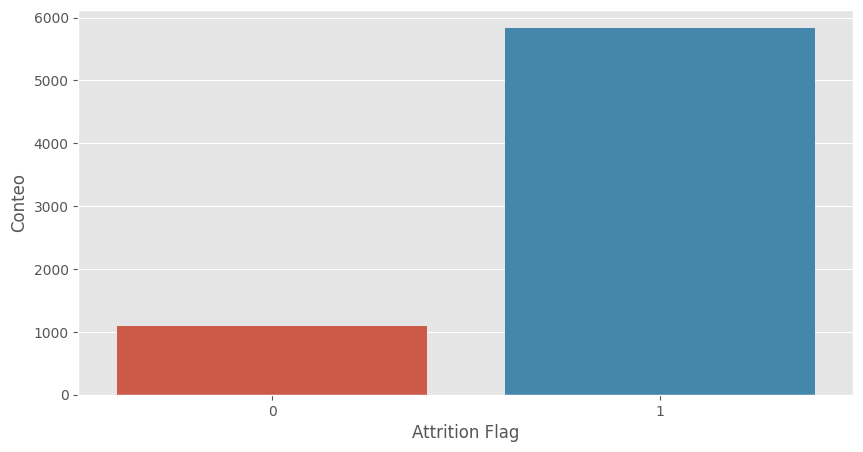

In [52]:
# Clases desbalanceadas
plt.figure(figsize=(10, 5))
sns.countplot(x='Attrition_Flag', data=datos)
plt.xlabel('Attrition Flag')
plt.ylabel('Conteo')
plt.show()

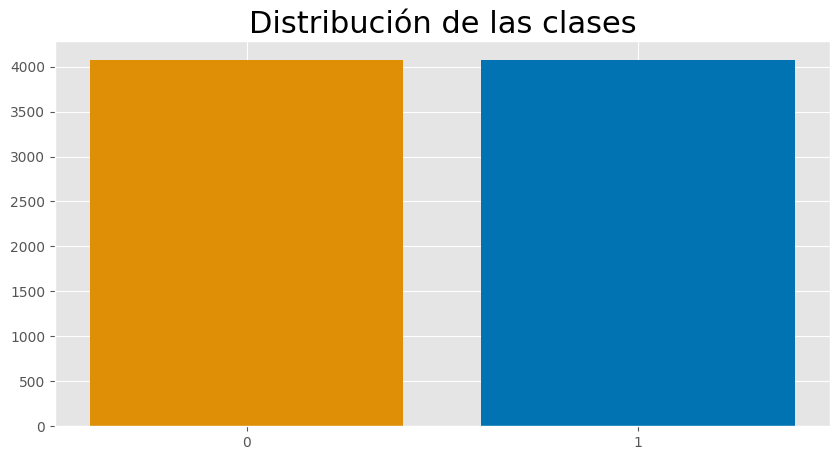

In [53]:
# Balanceo con sobremuestreo SMOTE

smote = SMOTE(k_neighbors=5, random_state=42)
X_train_balance, y_train_balance = smote.fit_resample(X_train, y_train)

class_counts = pd.Series(y_train_balance).value_counts()
plt.figure(figsize=(10, 5))
plt.bar(class_counts.index, class_counts, color=sns.color_palette('colorblind'))
plt.xticks(range(2))
plt.title('Distribución de las clases', size=22)
plt.show()

# Modelación

## Modelos lineales

### Naïve Bayes

In [54]:
# Crear la instancia
nb_classifier = GaussianNB()
# Entrenar el modelo
nb_classifier.fit(X_train_balance, y_train_balance)

# Predicción del modelo sobre los datos de entrenamiento
y_train_pred_nb = nb_classifier.predict(X_train_balance)

# Reporte de métricas de evaluación para clasificación
print(classification_report(y_train_balance, y_train_pred_nb))

              precision    recall  f1-score   support

           0       0.89      0.10      0.19      4078
           1       0.52      0.99      0.68      4078

    accuracy                           0.55      8156
   macro avg       0.71      0.55      0.44      8156
weighted avg       0.71      0.55      0.44      8156



## Grid-Search K-Flod Cross Validation

In [55]:
# KNN
grid_knn = {
    'n_neighbors':range(5, 11)
    }

gs_cv_knn = GridSearchCV(KNeighborsClassifier(),
                        param_grid=grid_knn,
                        verbose=1)

gs_cv_knn.fit(X_train_balance, y_train_balance)

print(f'Best Params: {gs_cv_knn.best_params_}')
print(f'Best Training Score: {gs_cv_knn.best_score_}')


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params: {'n_neighbors': 5}
Best Training Score: 0.88425752275159


In [56]:
# Árbol de Decisión
grid_dt = {
    'max_depth':range(4, 21, 2),
    'criterion':['gini', 'entropy']
}

gs_cv_dt = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=grid_dt,
                        verbose=1)

gs_cv_dt.fit(X_train_balance, y_train_balance)

print(f'Best Params: {gs_cv_dt.best_params_}')
print(f'Best Scoring: {gs_cv_dt.best_score_}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Params: {'criterion': 'gini', 'max_depth': 12}
Best Scoring: 0.9290155654536493


# Evaluación

## Predicciones sobre datos de prueba

In [57]:
# Predicciónes sobre las características de prueba

y_pred_nb = nb_classifier.predict(X_test)
y_pred_knn = gs_cv_knn.predict(X_test)
y_pred_dt = gs_cv_dt.predict(X_test)

## Reporte de clasificación

In [58]:
# Métricas de desempeño
print(f'{"-"*60}\n')
print('Naïve Bayes')
print(classification_report(y_test, y_pred_nb))
print(f'{"-"*60}\n')
print('KNN')
print(classification_report(y_test, y_pred_knn))
print(f'{"-"*60}\n')
print('Decicision Tree')
print(classification_report(y_test, y_pred_dt))
print(f'{"-"*60}')

------------------------------------------------------------

Naïve Bayes
              precision    recall  f1-score   support

           0       0.54      0.09      0.15       322
           1       0.85      0.99      0.92      1755

    accuracy                           0.85      2077
   macro avg       0.70      0.54      0.53      2077
weighted avg       0.81      0.85      0.80      2077

------------------------------------------------------------

KNN
              precision    recall  f1-score   support

           0       0.44      0.76      0.55       322
           1       0.95      0.82      0.88      1755

    accuracy                           0.81      2077
   macro avg       0.69      0.79      0.72      2077
weighted avg       0.87      0.81      0.83      2077

------------------------------------------------------------

Decicision Tree
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       322
           1       

In [59]:
# Accuracy balanceado

balanced_acc_dt = balanced_accuracy_score(y_test, y_pred_nb)
balanced_acc_rf = balanced_accuracy_score(y_test, y_pred_knn)
balanced_acc_xgb = balanced_accuracy_score(y_test, y_pred_dt)

print(f'Balanced Accuracy Score for Naïve Bayes Classifier: {balanced_acc_dt:.4f}')
print(f'Balanced Accuracy Score for KNN Classifier: {balanced_acc_rf:.4f}')
print(f'Balanced Accuracy Score for Decision Tree Classifier: {balanced_acc_xgb:.4f}')

Balanced Accuracy Score for Naïve Bayes Classifier: 0.5366
Balanced Accuracy Score for KNN Classifier: 0.7898
Balanced Accuracy Score for Decision Tree Classifier: 0.8587


# Ensambles

In [60]:
# Bosque Aleatorio
grid_rf = {
    'criterion':['gini', 'entropy'],
    'max_depth':range(5, 21, 5),
    'n_estimators':range(40, 61, 10),
    }

gs_cv_rf = GridSearchCV(RandomForestClassifier(),
                        param_grid=grid_rf,
                        verbose=1,
                        return_train_score=True)

gs_cv_rf.fit(X_train_balance, y_train_balance)

gs_cv_rf.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 40}

In [61]:
# XGBoost
grid_xgb = {
    'learning_rate': np.arange(0.01, 0.06, 0.02),
    'n_estimators': range(40, 61, 10),
    'max_depth': range(5, 8)
}


gs_cv_xgb = GridSearchCV(XGBClassifier(),
                         param_grid=grid_xgb,
                         verbose=1,
                         return_train_score=True)

gs_cv_xgb.fit(X_train, y_train)

gs_cv_xgb.best_params_


Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'learning_rate': 0.049999999999999996, 'max_depth': 6, 'n_estimators': 60}

In [62]:
# Predicciónes sobre las características de prueba

y_pred_rf = gs_cv_rf.predict(X_test)
y_pred_xgb = gs_cv_xgb.predict(X_test)

In [63]:
# Métricas de desempeño
print(f'{"-"*60}\n')
print('Random Forest')
print(classification_report(y_test, y_pred_rf))
print(f'{"-"*60}\n')
print('XGBoost')
print(classification_report(y_test, y_pred_xgb))


------------------------------------------------------------

Random Forest
              precision    recall  f1-score   support

           0       0.81      0.71      0.76       322
           1       0.95      0.97      0.96      1755

    accuracy                           0.93      2077
   macro avg       0.88      0.84      0.86      2077
weighted avg       0.93      0.93      0.93      2077

------------------------------------------------------------

XGBoost
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       322
           1       0.95      0.99      0.97      1755

    accuracy                           0.95      2077
   macro avg       0.93      0.86      0.89      2077
weighted avg       0.95      0.95      0.95      2077



In [64]:
# Accuracy balanceado

balanced_acc_dt = balanced_accuracy_score(y_test, y_pred_rf)
balanced_acc_rf = balanced_accuracy_score(y_test, y_pred_xgb)

print(f'Balanced Accuracy Score for Random Forest Classifier: {balanced_acc_dt:.4f}')
print(f'Balanced Accuracy Score for XGBoost Classifier: {balanced_acc_rf:.4f}')


Balanced Accuracy Score for Random Forest Classifier: 0.8415
Balanced Accuracy Score for XGBoost Classifier: 0.8637
